In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel.builder.aln import (
    ALN_EXC_DEFAULT_PARAMS,
    ALN_INH_DEFAULT_PARAMS,
    ALNNode,
)
from neurolib.models.multimodel.builder.thalamus import (
    TCR_DEFAULT_PARAMS,
    TRN_DEFAULT_PARAMS,
    ThalamicNode,
)
from neurolib.utils.stimulus import OrnsteinUhlenbeckProcess, SquareInput, ZeroInput
from tqdm import tqdm

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

In [6]:
class StimulatedThalamus:

    # all times in ms
    DURATION = 30000.0
    T_SPIN_UP = 5000.0
    DT = 0.01

    def __init__(self, glk=0.033, gh=0.062, tcr_noise=0.0):
        """
        Initialise thalamus model here.
        """
        tcr_params = {**TCR_DEFAULT_PARAMS, "g_LK": glk, "g_h": gh}
        trn_params = {**TRN_DEFAULT_PARAMS, "g_LK": glk}
        # init model
        self.model = ThalamicNode(tcr_params=tcr_params, trn_params=trn_params)
        self.model.index = 0
        self.model.idx_state_var = 0
        self.model.init_node()
        self.tcr_noise = tcr_noise

    def get_square_pulse_stim(self, stim_inp=0.0, period=10000):
        """
        Prepare square pulse stimulation.
        """
        stim = SquareInput(
            stim_start=None,
            amplitude=stim_inp / 1000.0,
            period=period,
        )

        tcr_input = OrnsteinUhlenbeckProcess(mu=0.0, sigma=self.tcr_noise, tau=5.0)
        tcr_input += stim

        trn_input = ZeroInput()
        trn_input += stim
        return (
            tcr_input.as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT),
            trn_input.as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT),
        )

    def _prepare_aln_ts(self, e, i, noise):
        params_update = {"a": 0.0, "b": 15.0, "tauA": 1000.0}
        aln = ALNNode(
            exc_params={**ALN_EXC_DEFAULT_PARAMS, **params_update},
            inh_params={**ALN_INH_DEFAULT_PARAMS, **params_update},
        )
        aln.index = 0
        aln.idx_state_var = 0
        aln.init_node()

        noise_exc = OrnsteinUhlenbeckProcess(
            mu=e,
            sigma=noise,
            tau=5,
            seed=42,
        ).as_array(self.DURATION + self.T_SPIN_UP, self.DT)
        noise_inh = OrnsteinUhlenbeckProcess(
            mu=i,
            sigma=noise,
            tau=5,
            seed=512,
        ).as_array(self.DURATION + self.T_SPIN_UP, self.DT)
        results = aln.run(
            duration=self.DURATION + self.T_SPIN_UP,
            dt=self.DT,
            noise_input=np.hstack([noise_exc, noise_inh]).T,
            backend="numba",
        )
        return results

    def get_aln_so(self, e, noise):
        aln_res = self._prepare_aln_ts(e=e, i=3.5, noise=noise)
        aln_ts = aln_res["r_mean_EXC"].values.squeeze()
        so_stim = aln_ts[:, np.newaxis]

        tcr_input = OrnsteinUhlenbeckProcess(
            mu=0.0, sigma=self.tcr_noise, tau=5.0
        ).as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT)
        tcr_input += so_stim

        trn_input = ZeroInput().as_array(self.DURATION + self.T_SPIN_UP, dt=self.DT)
        trn_input += so_stim

        return tcr_input, trn_input

    def run(self, tcr_input, trn_input):
        """
        Run the model.
        """
        results = self.model.run(
            duration=self.DURATION + self.T_SPIN_UP,
            dt=self.DT,
            noise_input=np.hstack([tcr_input, trn_input]).T,
            backend="numba",
        )
        tcr = results["r_mean_EXC"].isel({"node": 0}) * 1000.0
        trn = results["r_mean_INH"].isel({"node": 0}) * 1000.0

        results_df = pd.DataFrame(
            {
                "TCR": tcr.values,
                "TRN": trn.values,
                "stim_input": tcr_input.squeeze() * 1000.0,
            },
            index=tcr.time,
        )
        results_df.index.name = "time"
        return results_df.loc[self.T_SPIN_UP / 1000.0 :]


def plot_single(df, ax):
    ax.plot(df.index, df["TRN"], color="C1", alpha=0.7)
    ax.plot(df.index, df["TCR"], color="C0", alpha=0.7)
    sns.despine(trim=True, ax=ax)
    ax2 = ax.twinx()
    ax2.plot(df.index, df["stim_input"], color="k", linewidth=2.0, alpha=0.9)
    ax2.set_ylim([-10, 300.0])
    ax2.set_yticks([])
    sns.despine(trim=False, ax=ax2)

100%|██████████| 16/16 [03:40<00:00, 13.81s/it]
/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


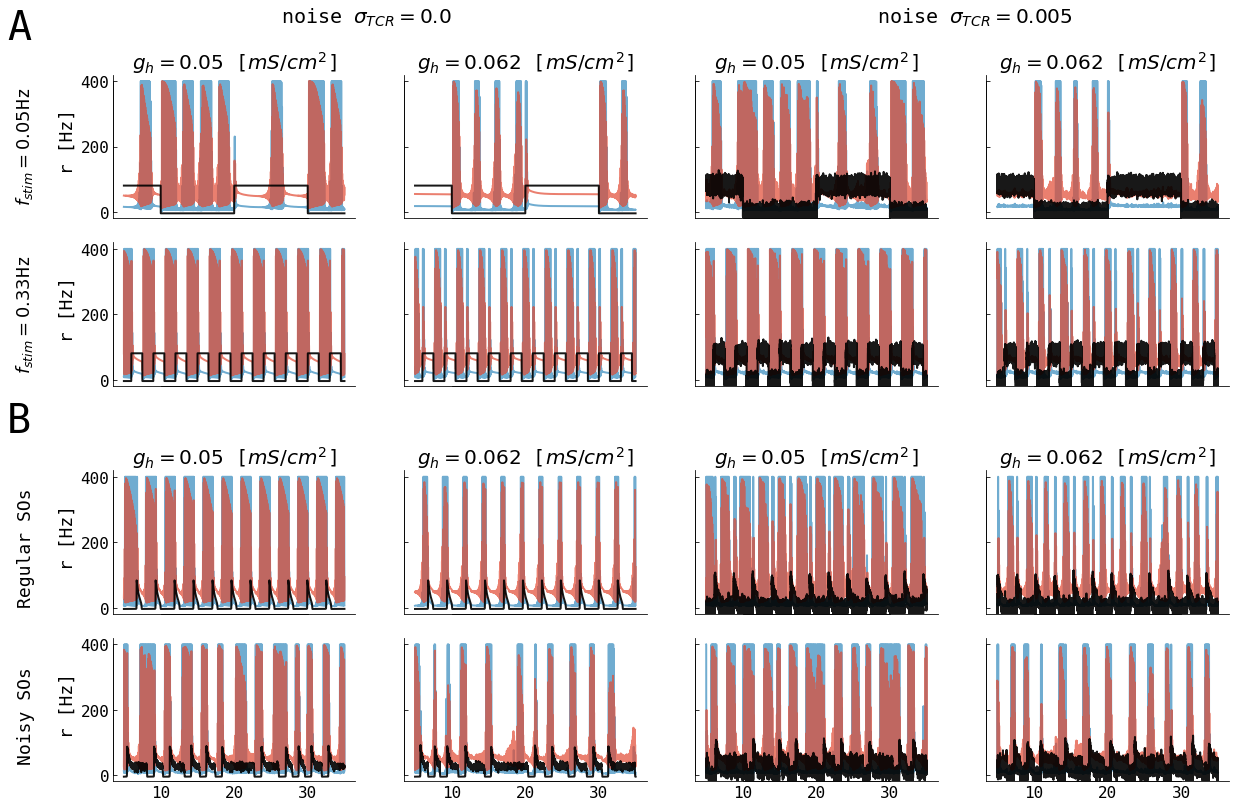

In [7]:
periods = [20000, 3000]
noises = [0.0, 0.005]
ghs = [0.05, 0.062]

fig, axs = plt.subplots(
    ncols=len(noises) * len(ghs),
    nrows=len(periods) + 3,
    sharex=True,
    sharey=True,
    figsize=(20, 13),
    gridspec_kw={"height_ratios": [1, 1, 0.25, 1, 1]},
)

for ax in axs[2, :]:
    ax.axis("off")

for i in range(axs.shape[1]):
    axs[2, i].axis("off")

pbar = tqdm(total=4 * len(noises) * len(ghs))
for i, period in enumerate(periods):
    for j, noise in enumerate(noises):
        for k, gh in enumerate(ghs):
            thalamus = StimulatedThalamus(gh=gh, tcr_noise=noise)
            tcr_inp, trn_inp = thalamus.get_square_pulse_stim(
                stim_inp=30.0, period=period
            )
            df = thalamus.run(tcr_inp, trn_inp)
            ax = axs[i, 2 * j + k]
            plot_single(df, ax)
            if i == 2:
                ax.set_xlabel("time [sec]")
            if i == 0:
                ax.set_title(f"$g_{{h}}={gh}$ [$mS/cm^2$]")
            if j + k == 0:
                ax.set_ylabel(f"$f_{{stim}}={1/(period / 1000.):.2f}$Hz" "\n\n r [Hz]")
            pbar.update(1)


aln_settings = [(3.2, 0.0, "Regular"), (3.7, 0.05, "Noisy")]
for i, (aln_e, aln_noise, subtitle) in enumerate(aln_settings):
    for j, noise in enumerate(noises):
        for k, gh in enumerate(ghs):
            thalamus = StimulatedThalamus(gh=gh, tcr_noise=noise)
            tcr_inp, trn_inp = thalamus.get_aln_so(e=aln_e, noise=aln_noise)
            df = thalamus.run(tcr_inp, trn_inp)
            ax = axs[len(periods) + 1 + i, 2 * j + k]
            plot_single(df, ax)
            if i == 2:
                ax.set_xlabel("time [sec]")
            if i == 0:
                ax.set_title(f"$g_{{h}}={gh}$ [$mS/cm^2$]")
            if j + k == 0:
                ax.set_ylabel(f"{subtitle} SOs \n\n r [Hz]")
            pbar.update(1)

pbar.close()

for j, noise in enumerate(noises):
    ax_tit = fig.add_subplot(1, 2, j + 1, frameon=False)
    ax_tit.set_title(f"noise $\sigma_{{TCR}}={noise}$ \n\n")
    ax_tit.set_xticks([])
    ax_tit.set_yticks([])

plt.text(
    0.06,
    0.93,
    "A",
    ha="center",
    va="center",
    transform=fig.transFigure,
    fontsize=40,
)
plt.text(
    0.06,
    0.51,
    "B",
    ha="center",
    va="center",
    transform=fig.transFigure,
    fontsize=40,
)
plt.tight_layout()
# to PDF due transparency
plt.savefig(
    "../figs/thalamus_square_stim_ts.pdf",
    dpi=DPI,
    transparent=True,
    bbox_inches="tight",
)